In [1]:
!pip install tweepy apyori networkx

import pandas as pd
import tweepy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from lib import progress_bar
import json
import re
from konlpy.tag import Okt
from collections import Counter
from apyori import apriori

import warnings
warnings.filterwarnings("ignore")

In [3]:
CONSUMER_KEY = "{YOUR_API_KEY}"
CONSUMER_SECRET = "{YOUR_API_SECRET_KEY}"
ACCESS_TOKEN_KEY = "{YOUR_ACCESS_TOKEN}"
ACCESS_TOKEN_SECRET = "{YOUR_ACCESS_TOKEN_SECRET}"
  
# Opening JSON file
with open('api_config.json','r') as f:
    config = json.load(f)
    CONSUMER_KEY = config['CONSUMER_KEY']
    CONSUMER_SECRET = config['CONSUMER_SECRET']
    ACCESS_TOKEN_KEY = config['ACCESS_TOKEN_KEY']
    ACCESS_TOKEN_SECRET = config['ACCESS_TOKEN_SECRET']

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN_KEY, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

In [4]:
KEYWORD = "머신러닝" # Keyword we want to analyze using Twitter API

Collect Data using Twitter API

In [5]:
tweets = api.search(KEYWORD)
columns = ['created', 'tweet_text']
df = pd.DataFrame(columns = columns)
print("Getting Data...")
dataSize = 100
for i in range(dataSize):
    tweets = api.search(KEYWORD)
    for tweet in tweets:
        tweet_text = tweet.text
        created = tweet.created_at
        row = [created, tweet_text]
        series = pd.Series(row, index = df.columns)
        df = df.append(series, ignore_index = True)
    progress_bar.progress_bar(i, dataSize)
progress_bar.progress_bar(dataSize, dataSize)
print("\nGetting Data Completed...")
df.head(3)

Getting Data...
[====================================================================================================] 100%
Getting Data Completed...


,created,tweet_text
0,2021-08-11 03:47:48,RT @kingkenny1967: MBA코스에서도 강사가 그랬다. 이력서는 무조건 ...
1,2021-08-11 03:30:22,학부 2학년이었기 때문에 굉장한 기술이나 숙련된 무언가가 없어서 처음에는 그냥 배우...
2,2021-08-11 03:22:46,RT @kingkenny1967: MBA코스에서도 강사가 그랬다. 이력서는 무조건 ...


Extract Keywords

In [6]:
def text_cleaning(text):
    regex = re.compile('[^ ㄱ-ㅣ가-힣]+') # For Korean
    result = regex.sub('', text)
    return result

df['clean_text'] = df['tweet_text'].apply(lambda x : text_cleaning(x))
df.head()

,created,tweet_text,clean_text
0,2021-08-11 03:47:48,RT @kingkenny1967: MBA코스에서도 강사가 그랬다. 이력서는 무조건 ...,코스에서도 강사가 그랬다 이력서는 무조건 검색해서 나오는 양식 첫 개 중에서 상...
1,2021-08-11 03:30:22,학부 2학년이었기 때문에 굉장한 기술이나 숙련된 무언가가 없어서 처음에는 그냥 배우...,학부 학년이었기 때문에 굉장한 기술이나 숙련된 무언가가 없어서 처음에는 그냥 배우던...
2,2021-08-11 03:22:46,RT @kingkenny1967: MBA코스에서도 강사가 그랬다. 이력서는 무조건 ...,코스에서도 강사가 그랬다 이력서는 무조건 검색해서 나오는 양식 첫 개 중에서 상...
3,2021-08-11 02:01:24,RT @kingkenny1967: MBA코스에서도 강사가 그랬다. 이력서는 무조건 ...,코스에서도 강사가 그랬다 이력서는 무조건 검색해서 나오는 양식 첫 개 중에서 상...
4,2021-08-11 01:55:34,RT @kingkenny1967: MBA코스에서도 강사가 그랬다. 이력서는 무조건 ...,코스에서도 강사가 그랬다 이력서는 무조건 검색해서 나오는 양식 첫 개 중에서 상...


In [7]:
# Other languages' stopwords available here: https://www.ranks.nl/stopwords
stopwords_path = "data/korean_stopwords.txt" # For Korean

with open(stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

In [8]:
def get_nouns(x):
    nouns_tagger = Okt()
    nouns = nouns_tagger.nouns(x)
    nouns = [noun for noun in nouns if len(noun) > 1] # Remove single character words
    nouns = [noun for noun in nouns if noun not in stopwords] # Remove stopwords
    return nouns

In [9]:
df['nouns'] = df['clean_text'].apply(lambda x : get_nouns(x))
print(df.shape)
df.head(3)

(1500, 4)


,created,tweet_text,clean_text,nouns
0,2021-08-11 03:47:48,RT @kingkenny1967: MBA코스에서도 강사가 그랬다. 이력서는 무조건 ...,코스에서도 강사가 그랬다 이력서는 무조건 검색해서 나오는 양식 첫 개 중에서 상...,"[코스, 강사, 이력서, 무조건, 검색, 양식, 상용, 머신, 러닝, 사용, 양식,..."
1,2021-08-11 03:30:22,학부 2학년이었기 때문에 굉장한 기술이나 숙련된 무언가가 없어서 처음에는 그냥 배우...,학부 학년이었기 때문에 굉장한 기술이나 숙련된 무언가가 없어서 처음에는 그냥 배우던...,"[학부, 학년, 때문, 기술, 숙련, 무언가, 처음, 그냥, 머신, 러닝, 활용, ..."
2,2021-08-11 03:22:46,RT @kingkenny1967: MBA코스에서도 강사가 그랬다. 이력서는 무조건 ...,코스에서도 강사가 그랬다 이력서는 무조건 검색해서 나오는 양식 첫 개 중에서 상...,"[코스, 강사, 이력서, 무조건, 검색, 양식, 상용, 머신, 러닝, 사용, 양식,..."


In [10]:
transactions = df['nouns'].tolist()
transactions = [transaction for transaction in transactions if transaction]
print(transactions[:3])

[['코스', '강사', '이력서', '무조건', '검색', '양식', '상용', '머신', '러닝', '사용', '양식', '인식'], ['학부', '학년', '때문', '기술', '숙련', '무언가', '처음', '그냥', '머신', '러닝', '활용', '서비스', '얼굴인식', '이용', '출석', '체크', '서비스'], ['코스', '강사', '이력서', '무조건', '검색', '양식', '상용', '머신', '러닝', '사용', '양식', '인식']]


Analyze Keyword using Association Rule

In [11]:
# Setup your own apriori settings based on the keyword for best representation
results = list(apriori(transactions, min_support=0.1, min_confidence=0.2, min_lift=1, max_length=2))
print(results[:3])

[RelationRecord(items=frozenset({'강사'}), support=0.4, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'강사'}), confidence=0.4, lift=1.0)]), RelationRecord(items=frozenset({'검색'}), support=0.4, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'검색'}), confidence=0.4, lift=1.0)]), RelationRecord(items=frozenset({'러닝'}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'러닝'}), confidence=1.0, lift=1.0)])]


In [12]:
columns = ['source', 'target', 'support']
network_df = pd.DataFrame(columns = columns)

for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]
        row = [items[0], items[1], result.support]
        series = pd.Series(row, index = network_df.columns)
        network_df = network_df.append(series, ignore_index=True)

network_df.head()

,source,target,support
0,검색,강사,0.4
1,강사,러닝,0.4
2,머신,강사,0.4
3,강사,무조건,0.4
4,강사,사용,0.4


In [29]:
tweet_corpus = ''.join(df['clean_text'].tolist())

from konlpy.tag import Okt
from collections import Counter

nouns_tagger = Okt()
nouns = nouns_tagger.nouns(tweet_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
node_df = pd.DataFrame(remove_char_counter.items(), columns = ['node', 'nodesize'])

node_df = node_df[node_df['nodesize'] >= 100]
node_df.head()

,node,nodesize
0,코스,600
1,강사,600
2,이력서,600
3,무조건,600
4,검색,600


Visualize Keyword Network

In [30]:
def drawNetwork(G, node_df, plt):
    for idx, row in node_df.iterrows():
        G.add_node(row['node'], nodesize=row['nodesize'])
    for idx, row in network_df.iterrows():
        G.add_weighted_edges_from([(row['source'], row['target'], row['support'])])
    pos = nx.spring_layout(G, k=0.6, iterations=50)
    sizes = [G.nodes[node]['nodesize']*25 for node in G]
    nx.draw(G, pos=pos, node_size=sizes)
    nx.draw_networkx_labels(G, pos=pos, font_family='AppleGothic', font_size=25)
    ax = plt.gca()
    plt.show()

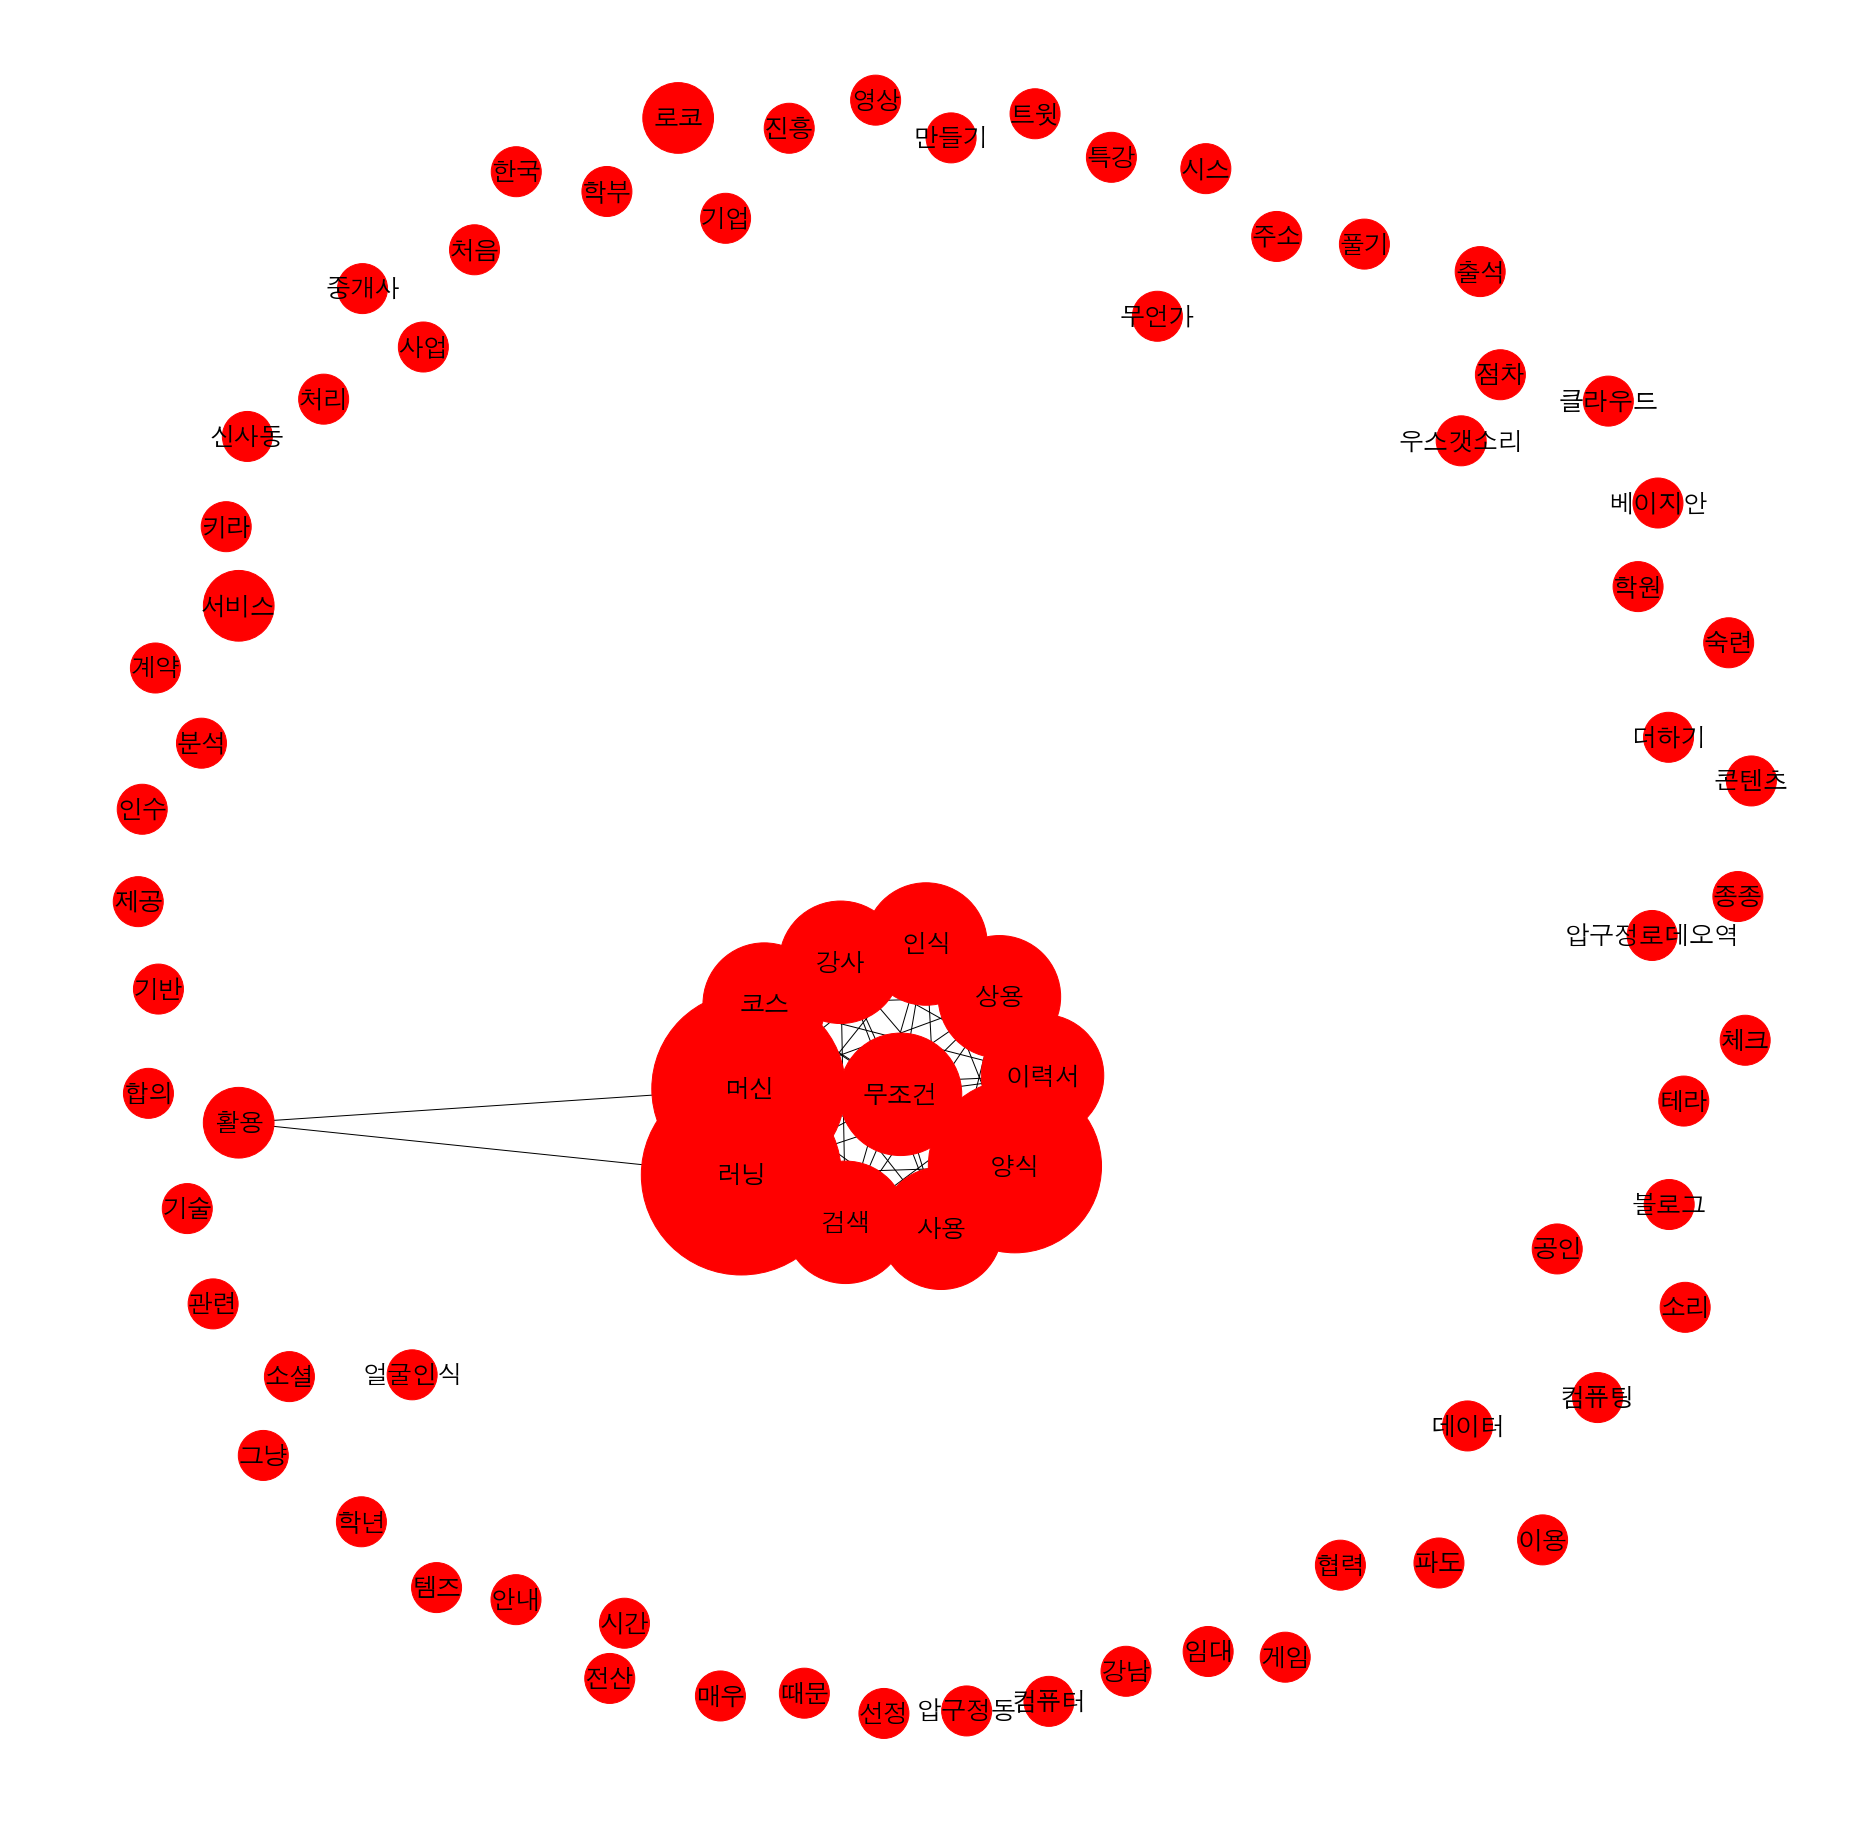

In [31]:
plt.figure(figsize=(25,25))
G = nx.Graph()
drawNetwork(G, node_df, plt)